## Diffusion form scratch in PyTorch and Lightning

No one have probably missed the recent boom and hype around Diffusion Models and their amazing results. Creating the most unimaginable images given a (the correct) text description. A couple of weeks ago Stability AI open sourced the powerful Stablediffusion model whom anyone can download and run. It is also fast enough to run locally on your own machine.

Now I have to admit that I have just barely scratched the surface of diffusion models and their details, I blame it on the impossible task of keeping up with high pace in the current machine learning community. So this post is about implementing a basic diffusion model in PyTorch and Lightning, train it on a dataset and at least touch on the details that make these model work. It will not be a dive to the depth of ocean, in those cases I will link to good resources that I have found useful for understanding the math and the derivation behind the equations. Lets start.

### Intro and High-level Intuition
So the basic idea of diffusion models is to learn a model that can create samples from some distribution, for example natural images, from noise. An analogy I like to have in mind is that the models are similar to a human forming a lump of clay into for example a cup, we start with something containing no information and slowly form something useful. 

The setup when training a diffusion model have two phases, a forward process, in which we over a set of timesteps $0:T$ add noise to an sample $\mathbf{x}_0$ so we end up with the sample at time $T$ only consisting of isotropic (uniform in all dimensions) gaussian noise with mean zero and variance one. Then we have a backward process where we do the opposite, go from the noisy sample $\mathbf{x}_T$ to the initial sample $\mathbf{x}_0$. It is this backward process we want to learn. The forward process is usually fixed and is just consisting of a noise scheduler which tells how much noise to add at each timestep. So, lets start with the forward process and take it from there.

#### Forward Diffusion Process

The noise is added by a variance schedule, $\{\beta\in(0,1)\}_{t=1}^{T}$. Lets create a function for that.

In [3]:
import torch

def linear_beta_schedule(timesteps: int, start: float = 0.0001, end: float = 0.02):
    """Creates a linear noise schedule"""
    return torch.linspace(start, end, timesteps)

Adding gaussian noise from one time step to the next is then defined by

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}\left(\mathbf{x}_t ; \sqrt{1 - \beta_t}\mathbf{x}_{t-1} , \beta_t\mathbf{I}\right)
$$

And the complete forward process can be written as

$$
q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) = \prod_{t=1}^{T}q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

If we then define a variable $\alpha_t \doteq 1 - \beta_t$ and use the fact that sampling from any normal distribution can be written as the mean plus the covariance times $\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$ (also known as the  reparameterization trick) we get that

$$
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 , (1 - \bar{\alpha_{t}})\mathbf{I})
\quad \Rightarrow \quad
\mathbf{x_t} = \sqrt{\bar{\alpha_{t}}} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha_{t}}}\epsilon
$$

Where $\bar{\alpha_t} = \prod_{i=0}^{t}\alpha_i$. So we see that we can sample $\mathbf{x_t}$ at any time $t$ given just $\mathbf{x}_0$, i.e we can sample in closed form. This is because a sums of gaussians is also gaussian. See [this excellent post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for derivation and details.

Our forward process function can then be implemented as

In [6]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image 'x_0' and a time step 't' and returns the noisy version of the image at time 't'
    """
    noise = torch.randn_like(x_0).to(device)
    
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)

    return (
        sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise, 
        noise
    )

That's it for the forward process! Now that we have it in place let us test with some data.

### Dataset

We are going to use the Food-101 dataset and for our purpose we only need to know it is a around a million images of food. Let us download it and plot some examples (keep in mind it is 5GB)

In [11]:
dataset = torchvision.datasets.Food101(root='.', download=True)

In [9]:
def show_images(dataset, num_samples=20, cols=4):
    """Plot some examples"""
    plt.figure(figsize=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])

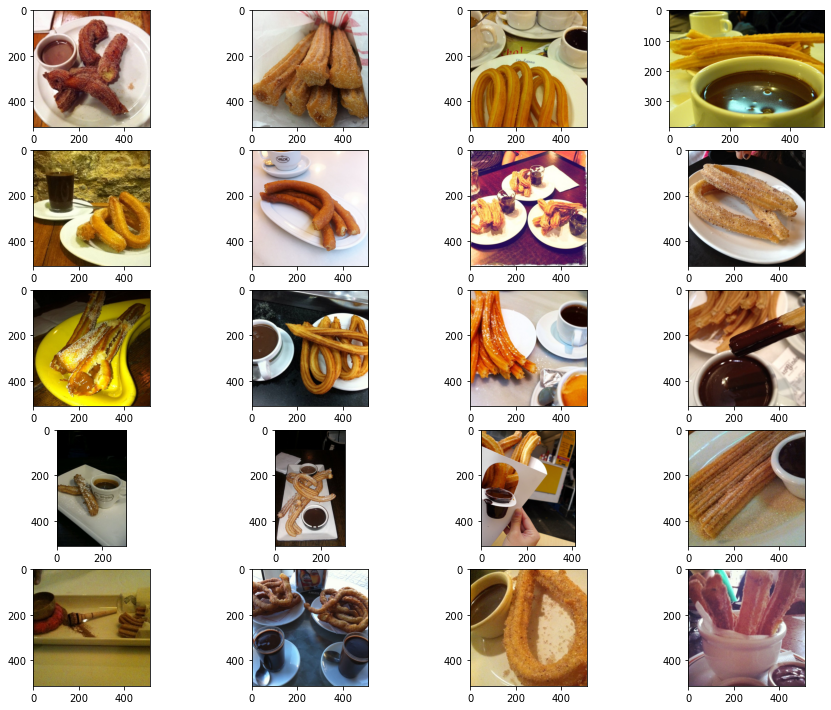

In [10]:
show_images(dataset)
plt.show()

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values 'vals' while considering the batch dimension
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# Number of time steps
T = 300

# Create the betas
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

#### Pre-calculations

#### Transform the data

In [ ]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_and_transform():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ])
    
    train = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform)
    test = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform, split='test')
    
    return (
        DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True), 
        DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True), 
    )

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

#### Let us test the forward diffusion

In [ ]:
train_dl, test_dl = load_and_transform()

In [ ]:
image = next(iter(test_dl))[0]

plt.figure(figsize=(30, 30))
plt.axis('off')
num_images = 10
stepsize = T // num_images

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, idx // stepsize + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

### Reverse diffusion process

So how do we go back? From noise to the original image? It might at first feel trivial since it was so easy to arrive at the noisy version. But remember, at each step when adding noise we lose information in a statistical fashion. In other words, we create an extremely large amount of possible ways to go back. In fact, to reverse the process and get back the original distribution we would have to integrate (marginalize) over all possible ways we could arrive at the original image $\mathbf{x_0}$ including all the latent (non observed) variables on the way. This is understandably intractable. So the only way we could manage this is by approximation!

Here comes neural networks, once again, to the rescue. So, the idea is to train a neural network parameterized by $\theta$ to approximate

$$ q(\mathbf{x}_{t-1} \vert \mathbf{x}_{t}) \approx p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$$

The first obvious way to do this would be to estimate the mean and covariance for each denoising step.

$$p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mu_{\theta}(\mathbf{x}_t, t), \Sigma_{\theta}(\mathbf{x}_t, t))$$

However the authors of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239v2.pdf) paper explored an alterative parameterization. Instead of estimating the mean we can make the network estimate the noise added at each time step, $\epsilon_{\theta}(\mathbf{x}_t, t)$. This since it can be shown that (jump into the paper for the derivation)

$$ \mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(\mathbf{x}_t, t) \right)$$

This simplifies the diffusion model’s variational bound and seemed to work better with a simplified training objective, sounds a bit scary but let's leave it there for now.

### Network Architecture

We will use the same architecture